### Libraries

In [1]:
import numpy                       
from matplotlib import pyplot    
%matplotlib inline
#
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

### Parameters

In [2]:
nx = 81
dx = 0.25
#
x_left = -10
x_right = 10
#
x = numpy.linspace(x_left,x_right,nx)
#
dt = .0002 
T_terminal = .01 #seconds
#
nt = int(T_terminal/dt)
#
gamma = 1.4

In [3]:
#left side:
rho_init_left = 1. #kg/m3
vel_init_left = 0. #m/s
P_init_left = 100000. #N/m2
#right side:
rho_init_right = 0.125 #kg/m3
vel_init_right = 0. #m/s
P_init_right = 10000. #N/m2

### Initial Condition, Flux Functions, and Slope Limiter

In [4]:
def get_U_initial(numx):
    u = numpy.zeros((3,numx),dtype=float)
    """
    Parameters:
    -----------
    numx - number of nodes
    """
    for i in range(numx):
        if (x[i] < 0):
            u[0,i] = rho_init_left
            u[1,i] = vel_init_left*rho_init_left
            u[2,i] = P_init_left/(gamma-1.)
        else:
            u[0,i] = rho_init_right
            u[1,i] = vel_init_right*rho_init_right
            u[2,i] = P_init_right/(gamma-1.)
    #
    return u

In [5]:
def get_Flux(Uv):
    """
    Parameters:
    -----------
    Uv - U vector of mass, momentum, and pressure
    """
    Fs= numpy.zeros_like(Uv)
    #
    Fs[0,:] = Uv[1,:]
    #
    Fs[1,:] = ((Uv[1,:]**2)/Uv[0,:]) + (gamma-1)*(Uv[2,:] - 0.5*(Uv[1,:]**2)/Uv[0,:])
    #
    Fs[2,:] = (Uv[2,:] + (gamma-1)*(Uv[2,:] - 0.5*(Uv[1,:]**2)/Uv[0,:]))*(Uv[1,:]/Uv[0,:])
    #
    return Fs

In [6]:
def rusanov_flux(Fl, Fr, Uvl, Uvr, delx, delt):
    
    Fs = numpy.zeros_like(Fl[:,1:])
    #
    Fs[0,:] = 0.5 * (Fr[0,1:] + Fl[0,:-1] - dx/dt * (Uvr[0,1:] - Uvl[0,:-1] ))
    Fs[1,:] = 0.5 * (Fr[1,1:] + Fl[1,:-1] - dx/dt * (Uvr[1,1:] - Uvl[1,:-1] ))
    Fs[2,:] = 0.5 * (Fr[2,1:] + Fl[2,:-1] - dx/dt * (Uvr[2,1:] - Uvl[2,:-1] ))
    #
    return Fs

In [7]:
def minmod(Uv, delx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    Uv : vectors of mass, momentum, and energy 
    delx : space step
    
    Returns
    -------
    sigma : vectors of minmod slope
    """
    
    sigma = numpy.zeros_like(Uv)
    dUv_minus = numpy.ones_like(Uv)
    dUv_plus = numpy.ones_like(Uv)
    #
    dUv_minus[:,1:] = (Uv[:,1:] - Uv[:,:-1])/delx
    dUv_plus[:,:-1] = (Uv[:,1:] - Uv[:,:-1])/delx
    #
    # minmod formulation:
    for i in range(1, len(Uv[0,:])-1):
        #
        if (dUv_minus[0,i] * dUv_plus[0,i] < 0.0) and (dUv_minus[1,i] * dUv_plus[1,i] < 0.0) \
        and (dUv_minus[2,i] * dUv_plus[2,i] < 0.0):
            sigma[:,i] = 0.0
        #
        elif (numpy.abs(dUv_minus[0,i]) < numpy.abs(dUv_plus[0,i])) \
        and (numpy.abs(dUv_minus[1,i]) < numpy.abs(dUv_plus[1,i]))\
        and (numpy.abs(dUv_minus[2,i]) < numpy.abs(dUv_plus[2,i])):
            sigma[:,i] = dUv_minus[:,i]
        #
        else:
            sigma[:,i] = dUv_plus[:,i]
            
    return sigma

U_initial = get_U_initial(nx)

S = minmod(U_initial, dx)

numpy.shape(S)

Uleft = numpy.zeros((3,nx))
Uright = numpy.zeros((3,nx))

Uleft[:,:] = U_initial[:,:] + S*dx/2.
Uright[:,:] = U_initial[:,:] - S*dx/2.

flux_left = get_Flux(Uleft)
flux_right = get_Flux(Uright)

numpy.shape(flux_left)

#Rusanov flux:
flux = rusanov_flux(flux_left, flux_right, Uleft, Uright, dx, dt)

numpy.shape(flux)

Ustar = numpy.zeros((3,nx))
#Rk2, step1:
Ustar[:,1:-1] = U_initial[:,1:-1] + dt/dx * (flux[:,:-1] - flux[:,1:])
#boundaries
Ustar[:,0] = U_initial[:,0]
Ustar[:,-1] = U_initial[:,-1]

### Solve MUSCLE

In [8]:
def muscl(U_init, numt, delt, delx, numx):
    """
    Parameters:
    -----------
    U_init - initial values of mass, momentum, and pressure
    numt - number of time steps
    delt - time step size
    delx - uniform node spacing
    numx - number of nodes
    
    Note that this code does not worry about boundary conditions since we don't let the shock and expansion waves
    reach the boundaries
    """
    Un = numpy.zeros((numt+1,3,numx))
    Un[:,:,:] = U_init[:,:]
    #
    Ustar = numpy.zeros((3,numx))
    Uleft = numpy.zeros((3,numx))
    Uright = numpy.zeros((3,numx))
    #Ustar[:,:] = U_init[:,:]
    #
    U = numpy.zeros((3,numx))
    U[:,:] = U_init[:,:]
    #
    for t in range(1,numt+1):
        #
        S = minmod(U,dx)
        #
        #reconstruct values at cell boundaries:
        Uleft[:,:] = U[:,:] + S*delx/2.
        Uright[:,:] = U[:,:] - S*delx/2.
        #
        flux_left = get_Flux(Uleft)
        flux_right = get_Flux(Uright)
        #
        #Rusanov flux:
        flux = rusanov_flux(flux_left, flux_right, Uleft, Uright, dx, dt)
        
        #Rk2, step1:
        Ustar[:,1:-1] = U_initial[:,1:-1] + dt/dx * (flux[:,:-1] - flux[:,1:])
        #boundaries
        Ustar[:,0] = U_initial[:,0]
        Ustar[:,-1] = U_initial[:,-1]
        #--------__-------------_-------#
        #
        S = minmod(Ustar, dx)
        #
        #reconstruct values at cell boundaries:
        Uleft[:,:] = Ustar[:,:] + S*delx/2.
        Uright[:,:] = Ustar[:,:] - S*delx/2.
        #
        flux_left = get_Flux(Uleft)
        flux_right = get_Flux(Uright)
        #
        flux = rusanov_flux(flux_left, flux_right, Uleft, Uright, dx, dt)
        #
        #RK2, step2:
        Un[t,:,1:-1] = 0.5* (U[:,1:-1] + Ustar[:,1:-1] + (delt/delx)*(flux[:,:-1] - flux[:,1:]) )
        U = Un[t,:,:].copy()
        #
    return Un[:,:,:]     

In [9]:
U_initial = get_U_initial(nx)

In [10]:
UN = muscl(U_initial, nt, dt, dx, nx)

/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in double_scalars
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in square
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in add
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: overflow encountered in square
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in add
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in add
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in add
/Users/Luis/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in subtract
/U

In [11]:
def animate(UN):
    x = numpy.linspace(x_left,x_right,nx)
    y = UN[0,:]
    line.set_data(x,y)
    return line,


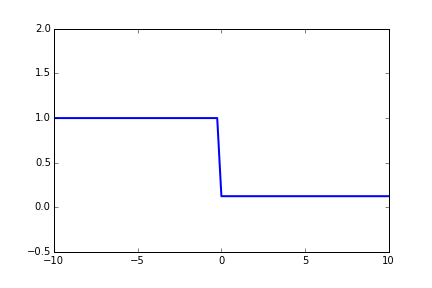
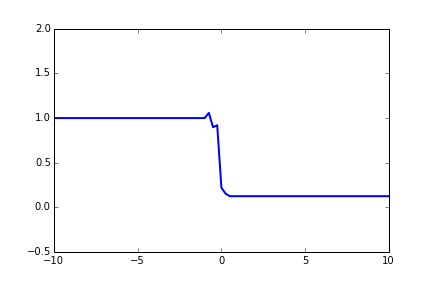
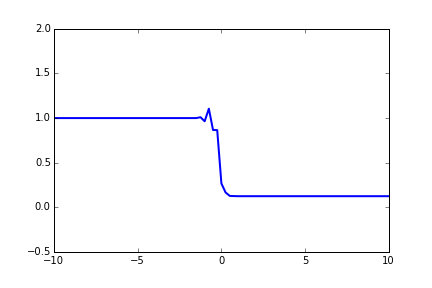
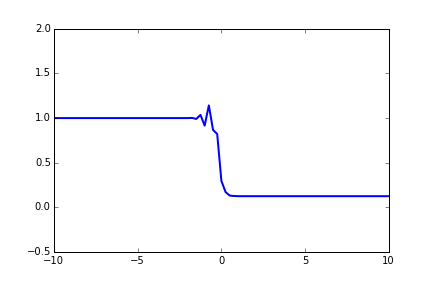
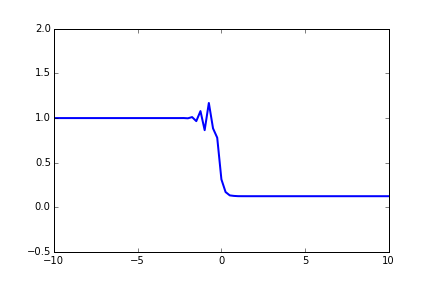
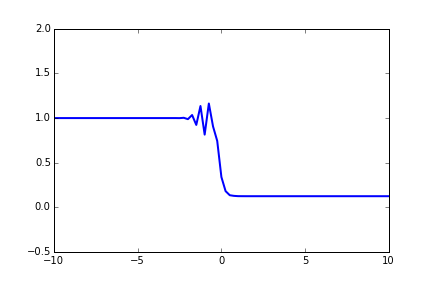
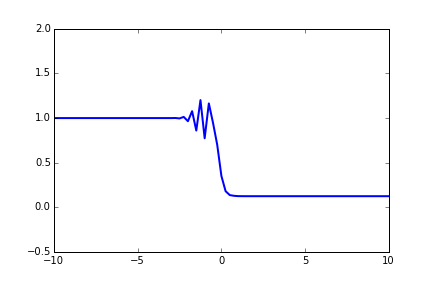
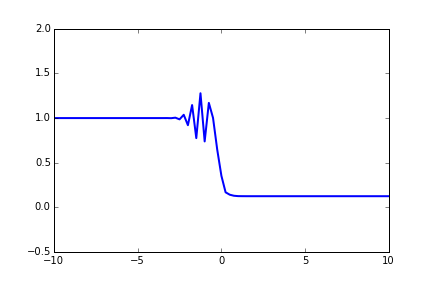
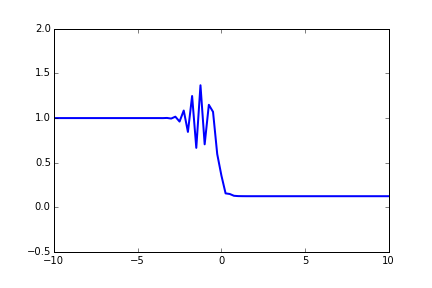
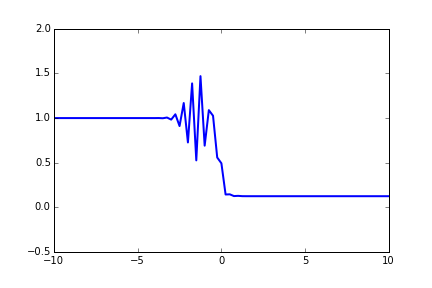
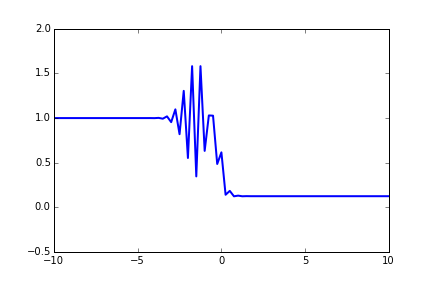
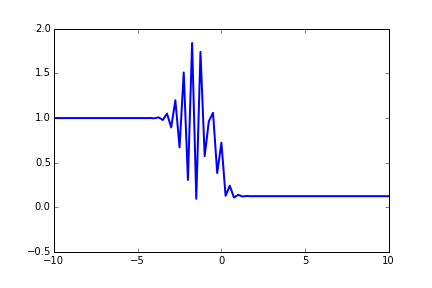
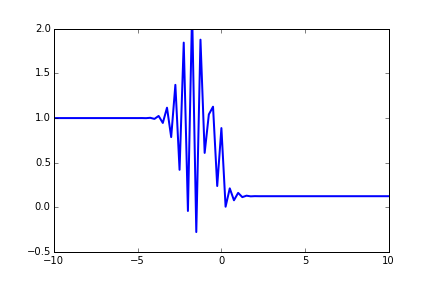
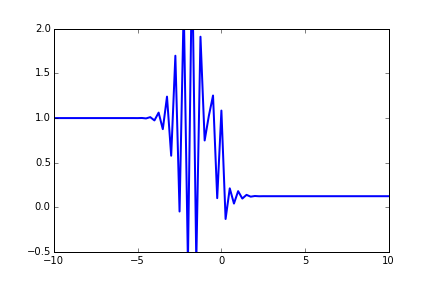
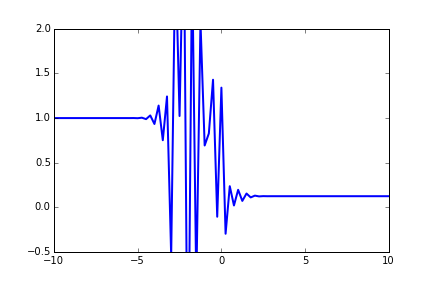
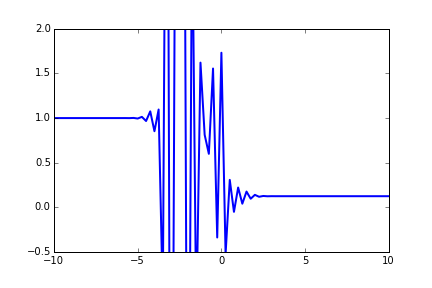
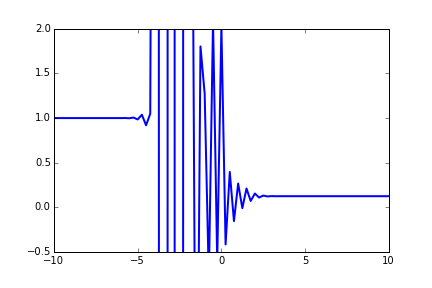
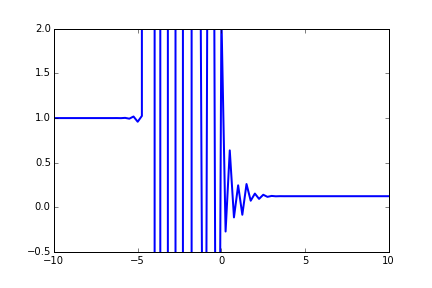
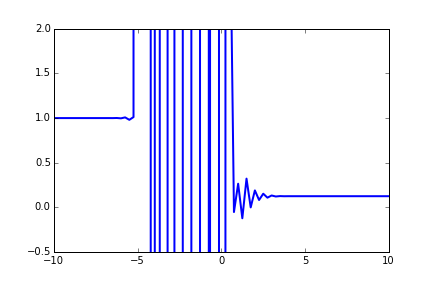
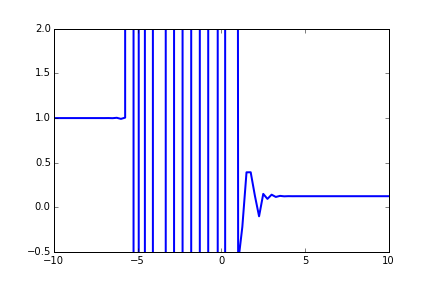
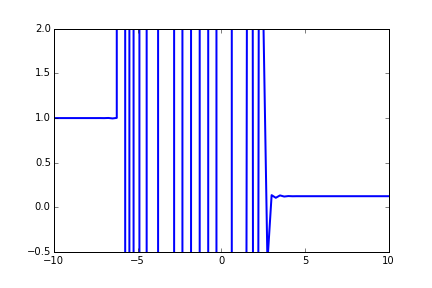
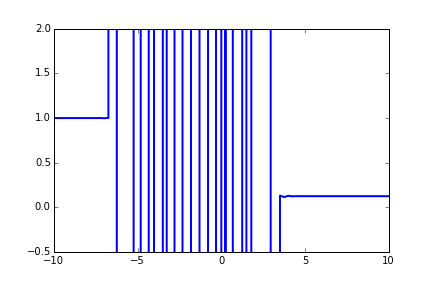
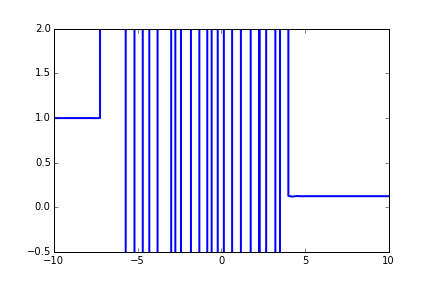
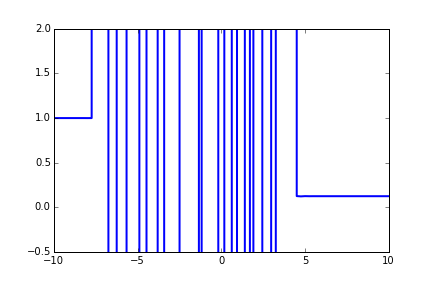
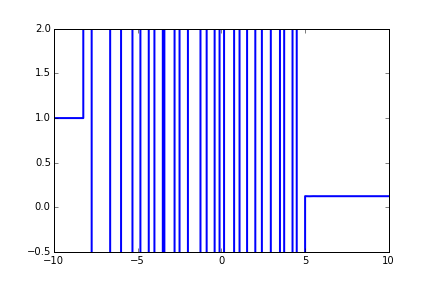
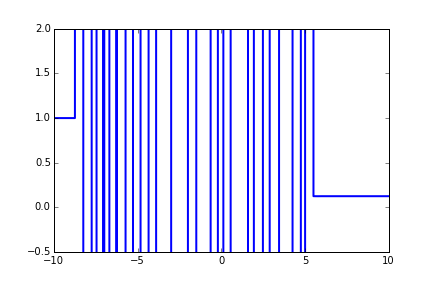
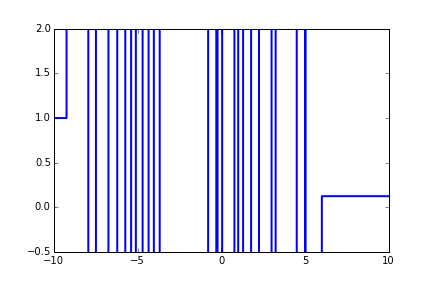
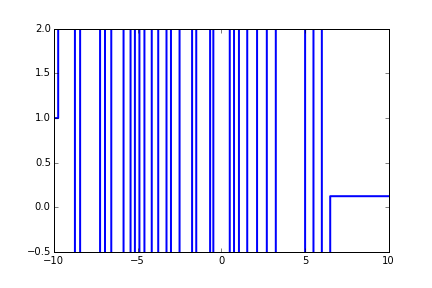
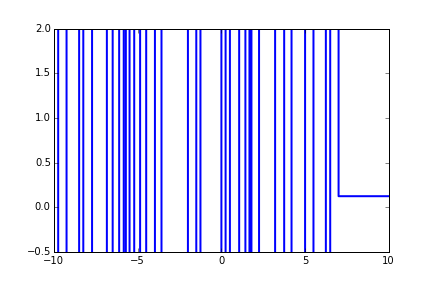
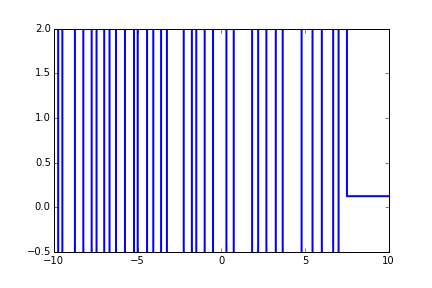
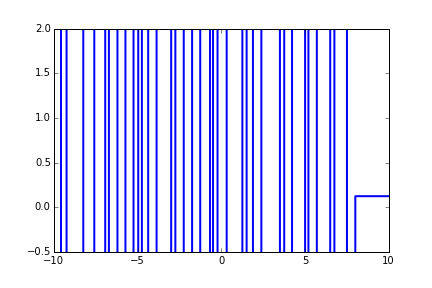
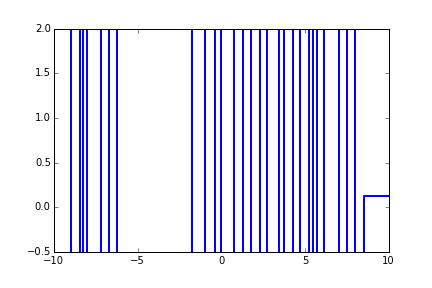
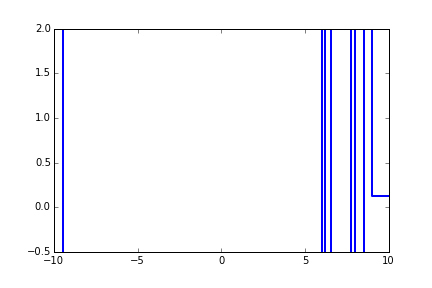
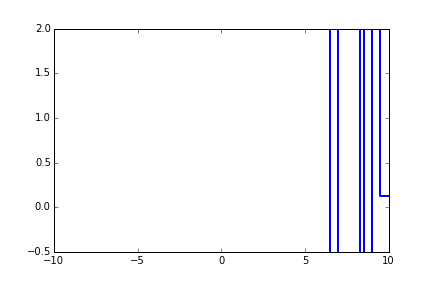
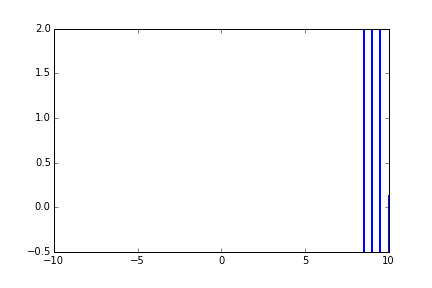
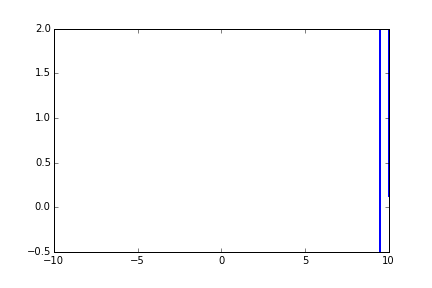
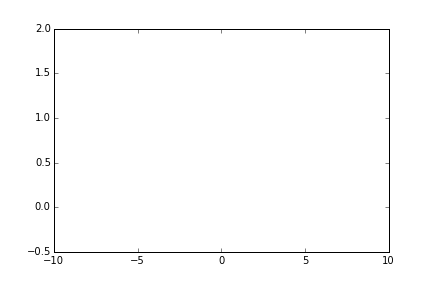
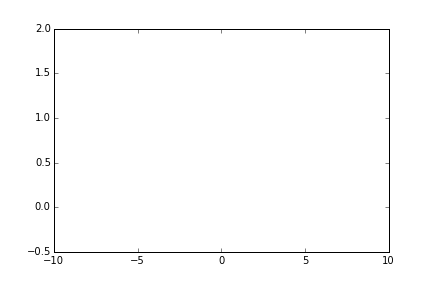
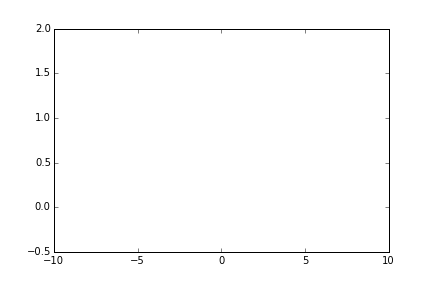
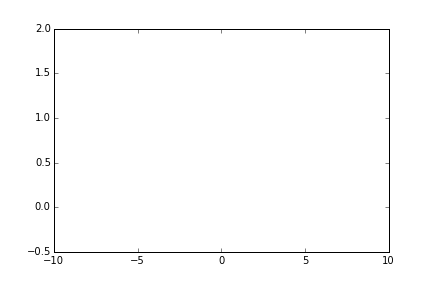
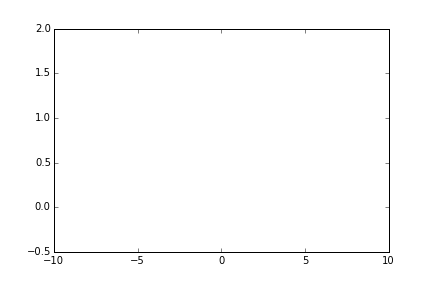
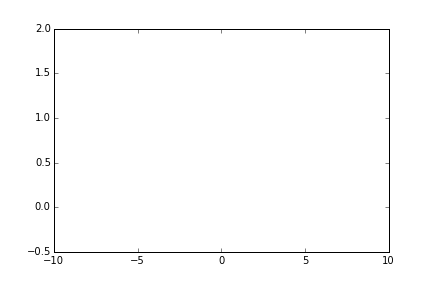
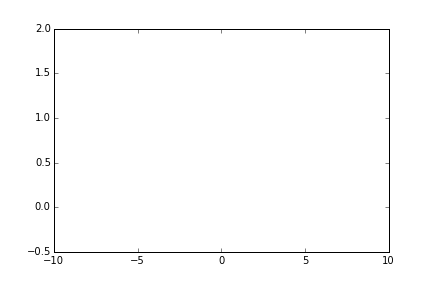
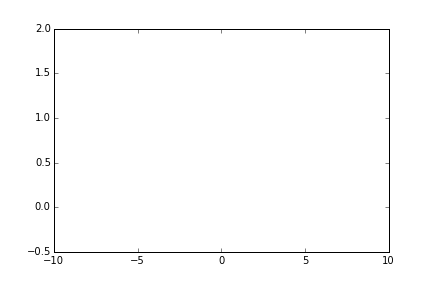
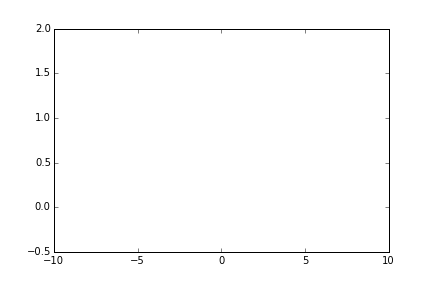
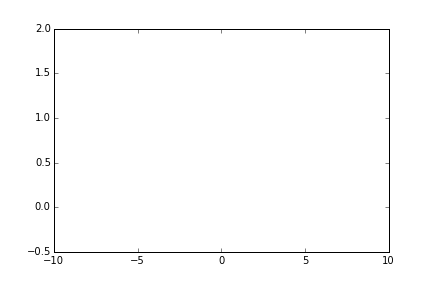
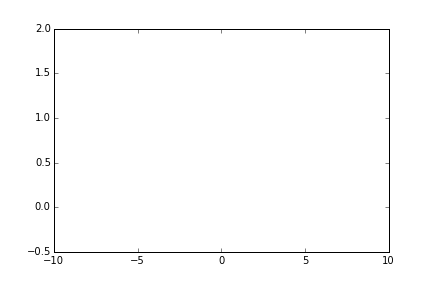
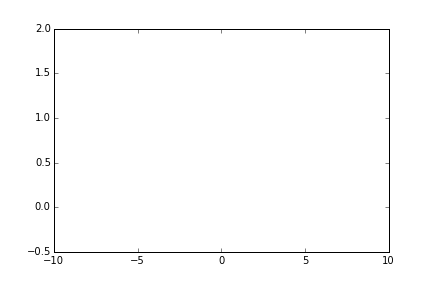
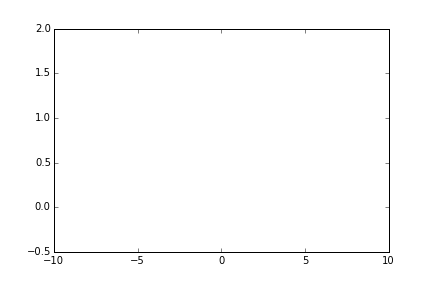
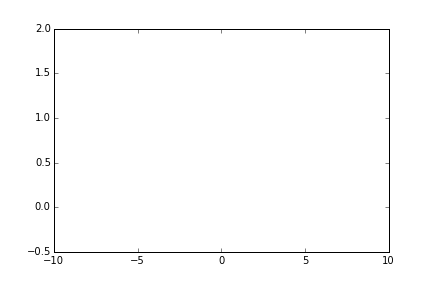
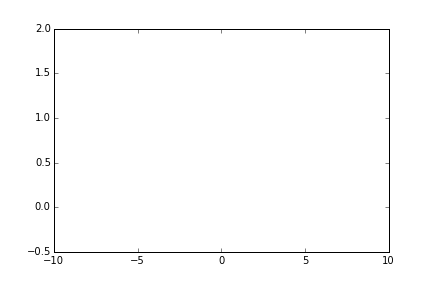

In [14]:
#density profile
fig = pyplot.figure();
ax = pyplot.axes(xlim=(-10,10),ylim=(-.5,2));
line, = ax.plot([],[],lw=2);

anim = animation.FuncAnimation(fig, animate, frames=UN, interval=100)
display_animation(anim, default_mode='once')

The solution is blowing up!